<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegressor" data-toc-modified-id="LinearRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegressor</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#DummyRegressor" data-toc-modified-id="DummyRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DummyRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [2]:
RND = 12345

In [3]:
data = pd.read_csv('/datasets/taxi.csv',  index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
clean_data = data
shift_data = data - data.shift()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
data.index.duplicated().sum()

0

**Вывод: Был загружен массив с данными. В таблице не обнаруженно пропусков и повторяющихся дат. Проведенно ресемплирование по одному часу**

## Анализ

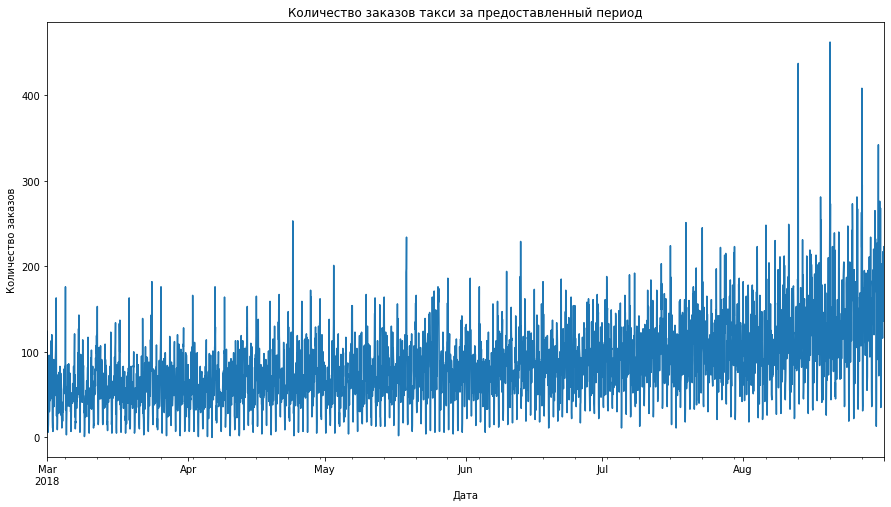

In [7]:
data['num_orders'].plot(figsize=(15,8))
plt.title('Количество заказов такси за предоставленный период')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

Для сглаживвания ряда применим скользящее среднее

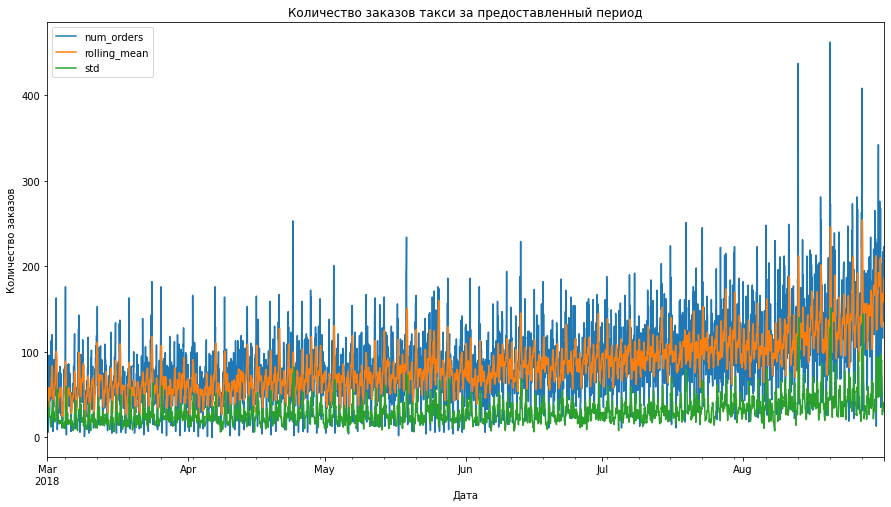

In [8]:
data['rolling_mean'] = data['num_orders'].rolling(7).mean()
data['std'] = data['num_orders'].rolling(7).std()
data.plot(figsize=(15,8))
plt.title('Количество заказов такси за предоставленный период')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

Видно, что после скользящее среднее все еще очень сильно колеблется

Проанализируем тренд и сезонность

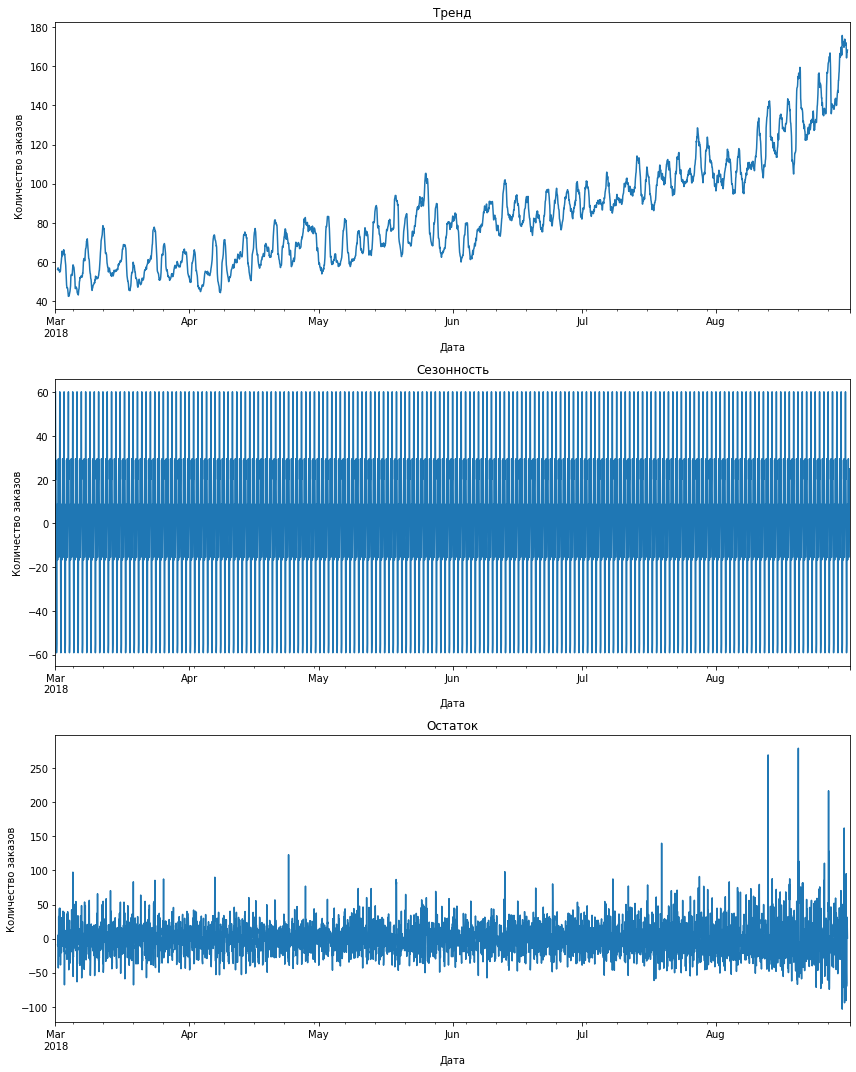

In [9]:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.tight_layout()

Разложение временного ряда на составляющие, показало что в данных присутствует тренд - увеличение заказов в течении года, также в данных присутствует шум. Выберем другой масштаб для рассмотрения сезонности.

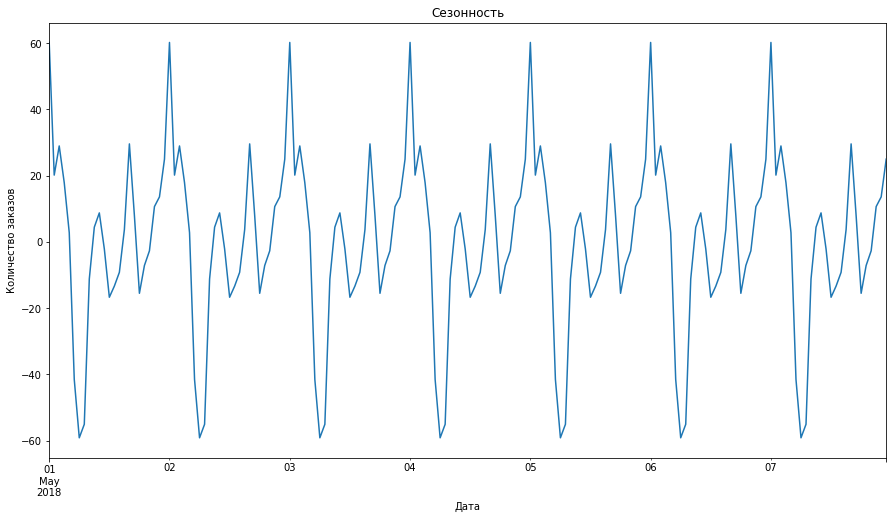

In [10]:
plt.figure(figsize=(15, 8))
decomposed.seasonal['2018-05-01':'2018-05-07'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

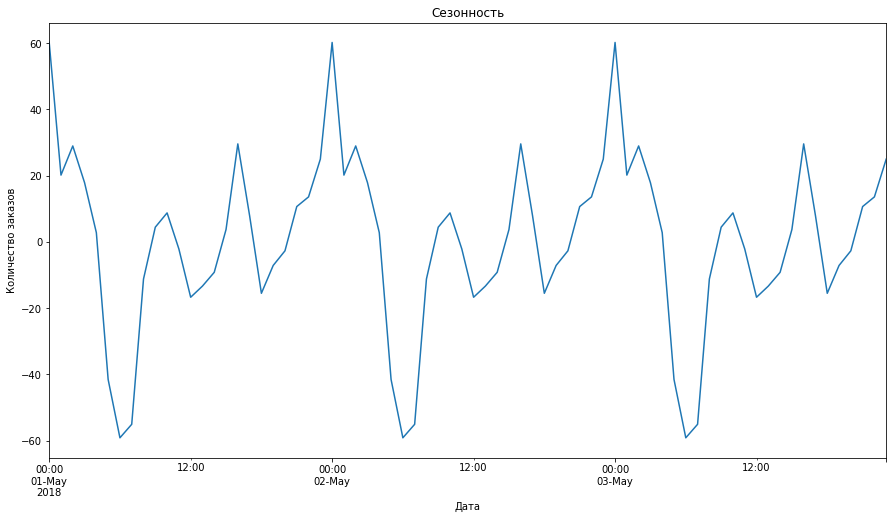

In [11]:
plt.figure(figsize=(15, 8))
decomposed.seasonal['2018-05-01':'2018-05-03'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

Видим, что присутсвует периодичность. Рост и спад количества заказов происходит в одно и то же время каждый день (резко увеличивается к 00:00 и спадает примерно к 6:00).

Рассмотрим разность временного ряда:

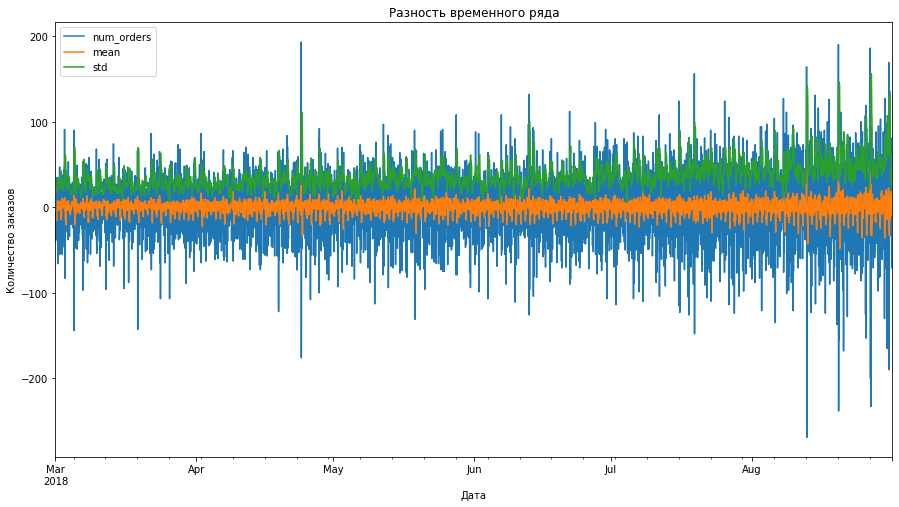

In [12]:
shift_data['mean'] = shift_data['num_orders'].rolling(7).mean()
shift_data['std'] = shift_data['num_orders'].rolling(7).std()
shift_data.plot(figsize=(15,8))
plt.title('Разность временного ряда')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.show()

Видно, что полученная разность является стационарной

**Вывод: Временной ряд сильно колеблется, в данных присутствует измение тренда за рассматриваемый период, ряд не является стационарным. Однако, разности временного ряда являются стационарными. Разложение временного ряда на тренд, сезонность и остаток показало, линейное увеличение заказов на протяжении года - положительный тренд, также в данных присутствует шум. Анализ сезонности показал, что присутствуют циклично-повторяющиеся закономерности с периодом 1 сутки и 1 неделя.**

## Обучение

Для обучения добавим в нашу таблицу признаки. Для этого напишем функцию, добавляющую год, месяц, день недели и день. Так же добавим отстающие значения и скользящее среднее.

In [13]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [14]:
clean_data = clean_data.drop(['std', 'rolling_mean'], axis=1)
clean_data = make_features(clean_data, 24, 168)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   int64  
 1   hour        4416 non-null   int64  
 2   dayofweek   4416 non-null   int64  
 3   lag_1       4415 non-null   float64
 4   lag_2       4414 non-null   float64
 5   lag_3       4413 non-null   float64
 6   lag_4       4412 non-null   float64
 7   lag_5       4411 non-null   float64
 8   lag_6       4410 non-null   float64
 9   lag_7       4409 non-null   float64
 10  lag_8       4408 non-null   float64
 11  lag_9       4407 non-null   float64
 12  lag_10      4406 non-null   float64
 13  lag_11      4405 non-null   float64
 14  lag_12      4404 non-null   float64
 15  lag_13      4403 non-null   float64
 16  lag_14      4402 non-null   float64
 17  lag_15      4401 non-null   float64
 18  lag_16      4400 non-nul

Разобьем выборку на тренировочную и тестовую 9:1

In [15]:
train, test = train_test_split(clean_data, shuffle=False, test_size=0.1)
train = train.dropna()

train_target = train['num_orders']
train_features = train.drop('num_orders', axis=1)

test_target = test['num_orders']
test_features = test.drop('num_orders', axis=1)

Рассмотрим несколько моделей

### LinearRegressor

In [16]:
%%time
lin_reg_model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
scores_list = cross_val_score(estimator=lin_reg_model, 
                              X=train_features, 
                              y=train_target, 
                              cv=tscv,  
                              scoring='neg_root_mean_squared_error')

val_score = scores_list.mean()
print("RMSE для LinearRegressor модели на тестовой выборке:", round(abs(val_score), 3))

RMSE для LinearRegressor модели на тестовой выборке: 27.074
CPU times: user 187 ms, sys: 391 ms, total: 578 ms
Wall time: 508 ms


### DecisionTreeRegressor

In [17]:
%%time
tree_model = DecisionTreeRegressor(criterion='mse', random_state=RND) 
tree_params = {'max_depth': list(np.arange(4, 12))}
tree_gsearch = GridSearchCV(estimator=tree_model, 
                            cv=tscv, 
                            param_grid=tree_params, 
                            n_jobs=-1, 
                            scoring='neg_root_mean_squared_error')

tree_gsearch.fit(train_features, train_target)

CPU times: user 895 ms, sys: 35.3 ms, total: 930 ms
Wall time: 977 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11]},
             scoring='neg_root_mean_squared_error')

In [18]:
print("Лучшие параметры для DecisionTreeRegressor:", tree_gsearch.best_params_)
print("RMSE для DecisionTreeRegressor модели на тестовой выборке:", round(abs(tree_gsearch.best_score_), 3))

Лучшие параметры для DecisionTreeRegressor: {'max_depth': 4}
RMSE для DecisionTreeRegressor модели на тестовой выборке: 30.278


### CatBoostRegressor

In [19]:
%%time
cat_model = CatBoostRegressor(loss_function='RMSE',
                              random_state=RND, 
                              verbose=False)
cat_params = {'learning_rate': [0.2, 0.5], 
              'n_estimators': [100, 600]}

cat_gsearch = GridSearchCV(estimator=cat_model, 
                            cv=tscv, 
                            param_grid=cat_params, 
                            n_jobs=-1, 
                            scoring='neg_root_mean_squared_error')

cat_gsearch.fit(train_features, train_target)

CPU times: user 29.2 s, sys: 538 ms, total: 29.8 s
Wall time: 48.6 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f8cb127dd90>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.5],
                         'n_estimators': [100, 600]},
             scoring='neg_root_mean_squared_error')

In [20]:
print("Лучшие параметры для CatBoostRegressor:", cat_gsearch.best_params_)
print("RMSE для CatBoostRegressor модели на тестовой выборке:", round(abs(cat_gsearch.best_score_), 3))

Лучшие параметры для CatBoostRegressor: {'learning_rate': 0.2, 'n_estimators': 100}
RMSE для CatBoostRegressor модели на тестовой выборке: 25.097


### DummyRegressor

In [21]:
%%time
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(train_features, train_target)

CPU times: user 957 µs, sys: 48 µs, total: 1 ms
Wall time: 792 µs


DummyRegressor(strategy='median')

In [22]:
%%time
dummy_predict = dummy_model.predict(train_features)

CPU times: user 236 µs, sys: 12 µs, total: 248 µs
Wall time: 269 µs


In [23]:
mse_dummy_model = mean_squared_error(train_target, dummy_predict)
print("RMSE для DummyRegressor модели на тестовой выборке:", round((mse_dummy_model) ** 0.5, 2))

RMSE для DummyRegressor модели на тестовой выборке: 38.82


**Вывод: было обученно 3 модели: `LinearRegressor`, `DecisionTreeRegressor`, `CatBoostRegressor`, а так же `DummyRegressor`, для проверки моделей на адекватность. Самой точной по метрике RMSE оказалась `CatBoostRegressor` $(RMSE = 25.097)$. при этом все три модели прошли проверку на адекватность, показав значение метрики меньше чем у `DummyRegressor` $(RMSE = 38.82)$. Для дальнейшего тестирования выберем модель `CatBoostRegressor`.**

## Тестирование

In [24]:
%%time
cat_prediction = cat_gsearch.best_estimator_.predict(test_features)

CPU times: user 3.49 ms, sys: 0 ns, total: 3.49 ms
Wall time: 3.12 ms


In [25]:
mse_cat_model = mean_squared_error(test_target, cat_prediction)
print("RMSE для DecisionTreeRegressor модели на тестовой выборке:", round((mse_cat_model) ** 0.5, 3))

RMSE для DecisionTreeRegressor модели на тестовой выборке: 42.583


**Вывод: Результат выбранной модели на тестовой выборке: $(RMSE = 42.583)$**

## Общий вывод

**Вывод:**
- Был загружен массив с данными. В ходе подготовки данных не обнаруженно пропусков и повторяющихся дат. 
- Проведенно ресемплирование по одному часу. 
- Выясненно, что временной ряд сильно колеблется, в данных присутствует измение тренда, ряд не является стационарным.
- Разности временного ряда являются стационарными. Разложение временного ряда на тренд, сезонность и остаток показало, линейное увеличение заказов на протяжении года - положительный тренд
- В данных присутствует шум. 
- Присутствуют циклично-повторяющиеся закономерности. 
- Было обученно 3 модели: LinearRegressor, DecisionTreeRegressor, CatBoostRegressior, а так же DummyRegressor, для проверки моделей на адекватность. 
- Самой точной по метрике RMSE оказалась LinearRegressor $(RMSE = 25.097)$.
- Результат выбранной модели на тестовой выборке $(RMSE = 42.583)$.